In [1]:
#setwd("/home/liyi/Dropbox/model")
X=read.csv("~/Dropbox/model/adults.recruits.merged.csv")
feature_name=c("year","lat","lon","sitenum","cover","filter_chla_mean","filter_sst_mean","filter_upw_mean","mytilus.rec")
X=X[feature_name]
tail(X,10)
#plot(X[,"filter_upw_mean"],X[,"cover"])
#plot(X[,"filter_upw_mean"],X[,"mytilus.rec"])

,year,lat,lon,sitenum,cover,filter_chla_mean,filter_sst_mean,filter_upw_mean,mytilus.rec
230,2004,44.82667,-124.0567,10,80.6889,3.662119,11.82645,-0.7602897,4.828388
231,2004,45.755,-123.965,51,3.7333,4.980644,14.21074,-2.71165,5.475286
232,2004,45.77,-123.97,9,0.1,4.980644,14.21074,-2.71165,5.481912
233,2004,45.91333,-123.9767,50,19.6667,5.567718,14.66006,-2.71165,5.569498
234,2004,47.86,-124.57,6,0.0667,7.603948,12.2733,-5.712865,6.462187
235,2004,47.87,-124.6,5,0.2,7.110147,12.55776,-5.712865,6.450858
236,2004,47.94,-124.6583,4,0.2333,7.252411,12.57206,-5.712865,6.46111
237,2004,48.31333,-124.66,3,11.5,5.044518,10.39646,-5.712865,6.698514
238,2004,48.3375,-124.6875,2,22.4333,4.839913,10.32589,-5.712865,6.697709
239,2004,48.38917,-124.65,1,61.8621,4.465045,9.895781,-5.712865,6.752841


In [2]:
nsample=dim(X)[1]
X["ycover"]=NA
for(i in 1:nsample){
    idx=(X[,"sitenum"]==X[i,"sitenum"])&(X[,"year"]==X[i,"year"]+1)
    
    if(sum(idx)){
        X[i,"ycover"]=X[idx,"cover"]
    }
    
   
}
X1=X[complete.cases(X),]
tail(X1)
dim(X1)

,year,lat,lon,sitenum,cover,filter_chla_mean,filter_sst_mean,filter_upw_mean,mytilus.rec,ycover
203,2003,47.86,-124.57,6,0.0667,6.434961,10.98421,-21.59063,24.11287,0.0667
204,2003,47.87,-124.6,5,0.5,5.851524,11.02573,-21.59063,24.2126,0.2
205,2003,47.94,-124.6583,4,2.2333,5.851045,11.06835,-21.59063,24.46497,0.2333
206,2003,48.31333,-124.66,3,0.4,3.596314,10.02666,-21.59063,24.90144,11.5
207,2003,48.3375,-124.6875,2,42.2333,3.835763,10.15215,-21.59063,25.01019,22.4333
208,2003,48.38917,-124.65,1,65.9333,3.634768,9.930523,-21.59063,24.9597,61.8621


[1] 190  10

In [6]:
unique(X1["year"])

,year
1,1999
17,2000
65,2001
113,2002
178,2003


In [3]:
y=X1["ycover"]
y[y[,1]==0,]=min(y[y[,1]!=0,])/2 # replace 0 to the minimum positive number
y=log(y) # take log of the species number
#head(y)

N=X1["cover"]
#head(N)

D=dist(X[X[,"year"]==2001,"lat"],diag = T,upper = T)
D=as.matrix(D)
for(i in 1:48){
    for(j in 1:48){
        if(i>j){
            D[i,j]=-D[i,j]
        }
    }
}

D=as.matrix(D)
D[1:6,1:6]

E=X1[,c("filter_chla_mean","filter_sst_mean","filter_upw_mean")]

,1,2,3,4,5,6
1,0.0000000,0.1083336,0.1283340,0.7283325,0.7383347,0.7483330
2,-0.10833359,0.00000000,0.02000046,0.61999893,0.63000107,0.63999939
3,-0.12833405,-0.02000046,0.00000000,0.59999847,0.61000061,0.61999893
4,-0.72833252,-0.61999893,-0.59999847,0.00000000,0.01000214,0.02000046
5,-0.738334656,-0.630001068,-0.610000610,-0.010002136,0.000000000,0.009998322
6,-0.748332977,-0.639999390,-0.619998932,-0.020000458,-0.009998322,0.000000000


In [5]:
snum=X[X[,"year"]==2001,"sitenum"]
snum

[1] 48 47 46 45 44 43 42 41 40 38 39 37 36 35 34 33 32 31 30 29 28 27 26 25 24
[26] 23 22 21 20 19 18 17 16 15 14 13 12 11 10 51  9 50  6  5  4  3  2  1

In [71]:
# log-likelihood function
logl0=function(t,y,N,D,E){
  n=dim(y)[1]
  f=rep(0,n) # value of the regression function
  yr=rep(0:2,each=48) # 3 years(0-2) used: 00-03 for X, 01-04 for y
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[2])^2/(t[3]^2)) # dispersal kernal (for the 48 sites)
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),] # number of species for 48 sites
    f[j]=t[1]+log(sum(Ker*Nj))+t[4]*E[j,1]+t[5]*E[j,2]+t[6]*E[j,3]+t[7]*E[j,1]^2+t[8]*E[j,2]^2+t[9]*E[j,3]^2 # dispersal + three environment terms
  }
  
  return(sum((y[,1]-f)^2)) # return the objective function
}


# do the optimization to find the parameters
#t0=c(1,0,1,10,10,10,10,10,10)
t0=c(1,0,1,10,10,20,10,10,20)

res0=nlm(logl0,t0,hessian=T,print.level=1,y=y,N=N,D=D,E=E,iterlim=1e4,steptol=1e-5)

ERROR: Error in (yr[j] * 48 + 1):((yr[j] + 1) * 48): NA/NaN argument


# This is for pisco dataset

$$
\begin{equation}
y=K+\log(\sum_{i=1}^{n_s}N_{ti}e^{-\frac{(d_{si}-\mu_d)^2}{\sigma_d^2}})+\beta_1e_{chi}+\beta_2e_{sst}+
\beta_3e_{upw}+\epsilon,
\end{equation}
$$

$$
\begin{equation}
A_{x,t+1}=[\sum_{i=1}^{n_s}A_{i,t}e^{-\frac{(d_{si}-\mu_d)^2}{\sigma_d^2}}]e^{\beta_0+\beta_1e_{upw}+
\beta_2e_{upw}^2}+\epsilon,
\end{equation}
$$

In [25]:
library(synchrony)
data(pisco.data)
y=subset(pisco.data,year>2000,select=c(mussel_abund)) # species number
y[y[,1]==0,]=min(y[y[,1]!=0,])/2 # replace 0 to the minimum positive number
y=log(y) # take log of the species number

N=subset(pisco.data,year<2003,select=c(mussel_abund)) # (past) species number
#D=coord2dist(pisco.data[1:48,1:2],lower.tri = F) # site distance
#D=coord2dist(cbind(pisco.data[1:48,1],rep(pisco.data[1,2],48)),lower.tri = F) # site distance
D=dist(pisco.data[1:48,1],diag = T,upper = T)
D=as.matrix(D)
for(i in 1:48){
    for(j in 1:48){
        if(i>j){
            D[i,j]=-D[i,j]
        }
    }
}
E=subset(pisco.data,year<2003,select=c(chl,sst,upwelling)) # Environment variable
D=as.matrix(D)
D[1:6,1:6]

,1,2,3,4,5,6
1,0.0000000,0.1083336,0.1283340,0.7283325,0.7383347,0.7483330
2,-0.10833359,0.00000000,0.02000046,0.61999893,0.63000107,0.63999939
3,-0.12833405,-0.02000046,0.00000000,0.59999847,0.61000061,0.61999893
4,-0.72833252,-0.61999893,-0.59999847,0.00000000,0.01000214,0.02000046
5,-0.738334656,-0.630001068,-0.610000610,-0.010002136,0.000000000,0.009998322
6,-0.748332977,-0.639999390,-0.619998932,-0.020000458,-0.009998322,0.000000000


In [26]:
# log-likelihood function
logl2=function(t,y,N,D,E){
  n=dim(y)[1]
  f=rep(0,n) # value of the regression function
  yr=rep(0:2,each=48) # 3 years(0-2) used: 00-03 for X, 01-04 for y
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[2])^2/(t[3]^2)) # dispersal kernal (for the 48 sites)
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),] # number of species for 48 sites
    f[j]=t[1]+log(sum(Ker*Nj))+t[4]*E[j,1]+t[5]*E[j,2]+t[6]*E[j,3]+t[7]*E[j,1]^2+t[8]*E[j,2]^2+t[9]*E[j,3]^2 # dispersal + three environment terms
  }
  
  return(sum((y[,1]-f)^2)) # return the objective function
}


# do the optimization to find the parameters
#t0=c(1,0,1,10,10,10,10,10,10)
t0=c(1,0,1,10,10,20,10,10,20)

res2=nlm(logl2,t0,hessian=T,print.level=1,y=y,N=N,D=D,E=E,iterlim=1e4,steptol=1e-5)
res2$estimate

iteration = 0
Step:
[1] 0 0 0 0 0 0 0 0 0
Parameter:
[1]  1  0  1 10 10 20 10 10 20
Function Value
[1] 2.122045e+12
Gradient:
[1]     27491699     -1758301     25335693     78249487    361077832
[6]   2072565820    374293237   4858458643 207291276196

iteration = 114
Parameter:
[1] -0.4573546269  1.3175969823  2.3590791104  0.3587083205 -0.1164384755
[6]  0.0126321397 -0.0401453764 -0.0094495968 -0.0001124905
Function Value
[1] 305.9591
Gradient:
[1]  0.49101322  7.51581734  1.61753681  0.24373287  0.97208249  0.03547507
[7] -0.04966438 -0.09805535  0.06221489

Successive iterates within tolerance.
Current iterate is probably solution.



[1] -0.4573546269  1.3175969823  2.3590791104  0.3587083205 -0.1164384755
[6]  0.0126321397 -0.0401453764 -0.0094495968 -0.0001124905

[1] "MSE in log scale is:  2.12471568155564"


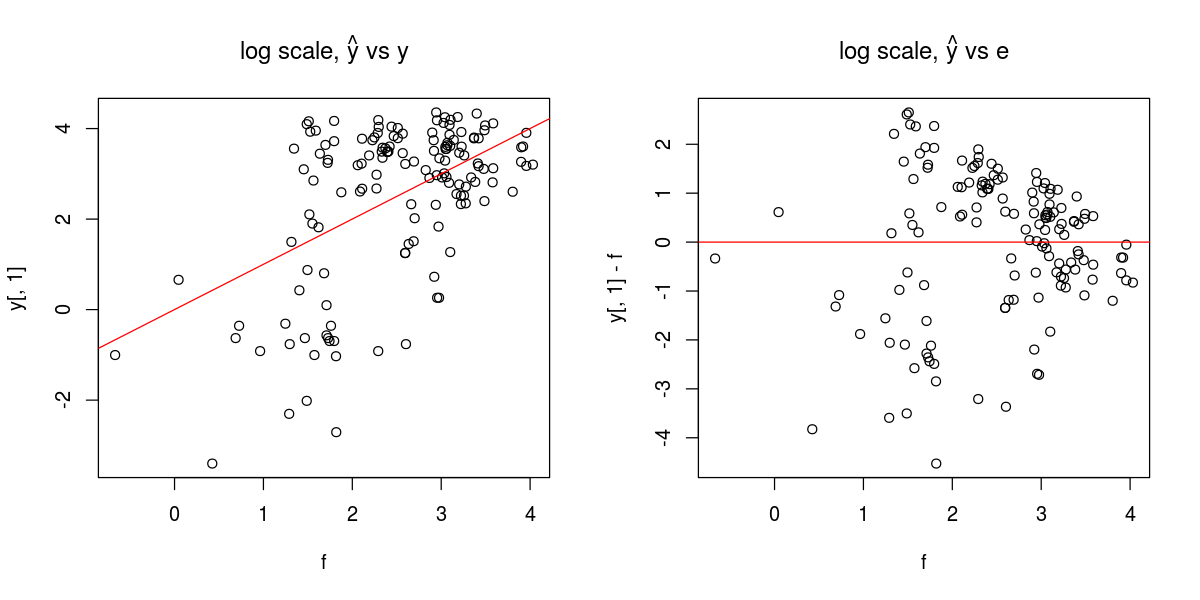

In [27]:
t=res2$estimate
n=dim(y)[1]
  f=rep(0,n) # value of the regression function
  yr=rep(0:2,each=48) # 3 years(0-2) used: 00-03 for X, 01-04 for y
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[2])^2/(t[3]^2)) # dispersal kernal (for the 48 sites)
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),] # number of species for 48 sites
    f[j]=t[1]+log(sum(Ker*Nj))+t[4]*E[j,1]+t[5]*E[j,2]+t[6]*E[j,3]+t[7]*E[j,1]^2+t[8]*E[j,2]^2+t[9]*E[j,3]^2 # dispersal + three environment terms
  }
MSE=mean((y[,1]-f)^2)
print(paste("MSE in log scale is: ",MSE))
par(mfrow=c(1,2))
options(repr.plot.width = 10)
options(repr.plot.height = 5)
plot(f,y[,1],main=expression(paste("log scale, ", hat(y)," vs y")))
abline(a=0,b=1,col=2)
plot(f,y[,1]-f,main=expression(paste("log scale, ", hat(y)," vs e")))
abline(a=0,b=0,col=2)

$$
\begin{equation}
y=\log(e^K\sum_{i=1}^{n_s}N_{ti}e^{-\frac{(d_{si}-\mu_d)^2}{\sigma_d^2}})+\beta_1e_{chi}+\beta_2e_{sst}+
\beta_3e_{upw}+\epsilon,
\end{equation}
$$

$$
\begin{equation}
=K+\log(\sum_{i=1}^{n_s}N_{ti}e^{-\frac{(d_{si}-\mu_d)^2}{\sigma_d^2}})+\beta_1e_{chi}+\beta_2e_{sst}+
\beta_3e_{upw}+\epsilon,
\end{equation}
$$

In [28]:
# log-likelihood function
logl1=function(t,y,N,D,E){
  n=dim(y)[1]
  f=rep(0,n) # value of the regression function
  yr=rep(0:2,each=48) # 3 years(0-2) used: 00-03 for X, 01-04 for y
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[2])^2/(t[3]^2)) # dispersal kernal (for the 48 sites)
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),] # number of species for 48 sites
    f[j]=t[1]+log(sum(Ker*Nj))+t[4]*E[j,1]+t[5]*E[j,2]+t[6]*E[j,3] # dispersal + three environment terms
  }
  
  return(sum((y[,1]-f)^2)) # return the objective function
}


# do the optimization to find the parameters
t0=c(1,0,1,0.1,0.1,0.1)
res1=nlm(logl1,t0,hessian=T,print.level=1,y=y,N=N,D=D,E=E,iterlim=1e4,steptol=1e-5)
res1$estimate

iteration = 0
Step:
[1] 0 0 0 0 0 0
Parameter:
[1] 1.0 0.0 1.0 0.1 0.1 0.1
Function Value
[1] 16552.29
Gradient:
[1]   2640.2677    223.2813   2436.9812   7644.3689  35891.0001 187877.4232

iteration = 61
Parameter:
[1]  1.0191051955 -0.0035246753 -0.0106411733  0.0001333653 -0.1045139552
[6]  0.0015669502
Function Value
[1] 106.6706
Gradient:
[1] -1.40124793  0.02515411  0.22112269  0.03462215  0.01106416 -0.54526949

Successive iterates within tolerance.
Current iterate is probably solution.



[1]  1.0191051955 -0.0035246753 -0.0106411733  0.0001333653 -0.1045139552
[6]  0.0015669502

[1] "MSE in log scale is:  0.740768043728402"


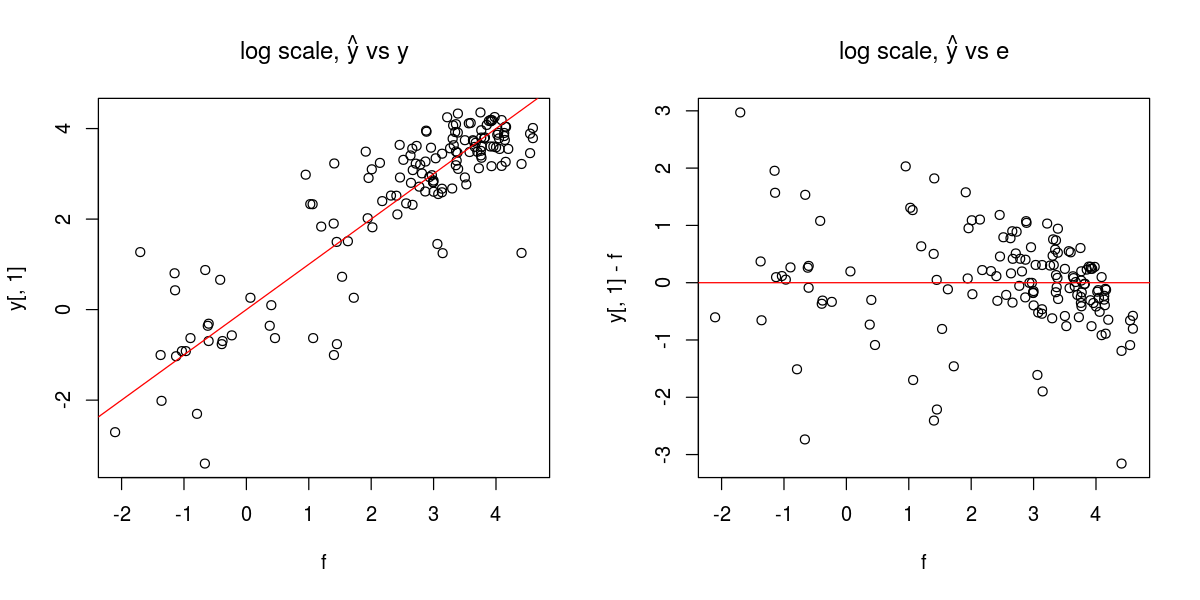

In [29]:
t=res1$estimate
n=dim(y)[1]
  f=rep(0,n) # value of the regression function
  yr=rep(0:2,each=48) # 3 years(0-2) used: 00-03 for X, 01-04 for y
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[2])^2/(t[3]^2)) # dispersal kernal (for the 48 sites)
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),] # number of species for 48 sites
    f[j]=t[1]+log(sum(Ker*Nj))+t[4]*E[j,1]+t[5]*E[j,2]+t[6]*E[j,3] # dispersal + three environment terms
  }
MSE=mean((y[,1]-f)^2)
print(paste("MSE in log scale is: ",MSE))
par(mfrow=c(1,2))
options(repr.plot.width = 10)
options(repr.plot.height = 5)
plot(f,y[,1],main=expression(paste("log scale, ", hat(y)," vs y")))
abline(a=0,b=1,col=2)
plot(f,y[,1]-f,main=expression(paste("log scale, ", hat(y)," vs e")))
abline(a=0,b=0,col=2)